# Inteligencia Artificial Proyecto #2: Clasificación
## Integrantes
    - Luis Berrospi
    - Pedro Dominguez
    - Carlos Esteban Guerrero Robles

### Imports

In [42]:
import pandas as pd
import numpy as np
import os

#Librerías que permitirá reducir dimensiones
import pywt
import pywt.data

#Librerías para lectura/edición de imágenes
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

#Librerías para generar gráficas
import matplotlib.pyplot as plt
from tabulate import tabulate

#Librerías de modelos de clasificación
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold # k fold cross validation
from sklearn import metrics # k fold cross validation
from sklearn.metrics import recall_score, average_precision_score, roc_auc_score, f1_score, precision_score

### Lectura de datos

In [43]:
train_csv_path = "../data/sign_mnist_train.csv"

df_train = pd.read_csv(train_csv_path)
df_train_x = df_train.loc[:, "pixel1":"pixel784"]
df_train_y = df_train.label

df_train = df_train.to_numpy()

test_csv_path = "../data/sign_mnist_test.csv"

df_test = pd.read_csv(test_csv_path)
df_test_x = df_test.loc[:, "pixel1":"pixel784"]
df_test_y = df_test.label

df_test = df_test.to_numpy()

### Reducción de dimensionalidad

In [44]:
def reduce_dimension(letter, cuts, wavelet):
  for i in range(cuts):
    (letter, cD) = pywt.dwt(letter, wavelet)
  return letter

def vectorizar(matrix):
  return matrix.flatten()

def proccess_letters(dataset, wavelet, cuts = 2):
  
  data_X = []
  data_Y = []

  for letter_features in dataset:
      
      letter = letter_features[0]
      data_Y.append(letter)

      letter_features = reduce_dimension(letter_features[1:], cuts, wavelet)
      letter_features = vectorizar(letter_features)
      data_X.append(letter_features)

  return data_X, data_Y

#### Wavelet families

In [45]:
discrete_family_wavelets = ['haar', 'bior', 'coif', 'rbio', 'sym', 'db', 'dmey']
discrete_wavelets = {family:pywt.wavelist(family) for family in discrete_family_wavelets}

#### Dimension cuts

In [46]:
dimension_cuts = range(6)

#### Kernels

In [47]:
kernels = ["linear", "poly", "rbf", "sigmoid"]

#### Neighbors

In [48]:
k_neighbors_list = [3, 6, 12, 24, 48]

#### PCA

In [49]:
#print(df_train.shape)
#print(df_test.shape)
random_state = 0
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

### Experiments

#### Wavelet experiment

In [50]:
def wavelet_experiment(classification, get_accuracy):
    experiment_wavelets = dict()

    for family, wavelets in discrete_wavelets.items():
        wavelets_accuracy_list = list()
        
        for wavelet in wavelets:
            df_train_x, df_train_y = proccess_letters(df_train, wavelet)
            df_test_x, df_test_y = proccess_letters(df_test, wavelet)

            prediction = classification(df_train_x, df_train_y, df_test_x)
            accuracy = get_accuracy(prediction)

            wavelets_accuracy_list.append((wavelet, accuracy))
        
        experiment_wavelets[family] = wavelets_accuracy_list
    
    return experiment_wavelets

#### Dimension experiment

In [51]:
def dimension_experiment(classification, get_accuracy, wavelet):
    experiment_dimensions = dict()

    print("Cuts Dimensions Accuracy")
    
    for cut in dimension_cuts:

        df_train_x, df_train_y = proccess_letters(df_train, wavelet, cuts=cut)
        df_test_x, df_test_y = proccess_letters(df_test, wavelet, cuts=cut)

        prediction = classification(df_train_x, df_train_y, df_test_x)
        accuracy = get_accuracy(prediction)

        dimensions = len(df_train_x[0])
        
        print(f'{cut}   {dimensions}       {accuracy}')
        experiment_dimensions[cut] = [(dimensions, accuracy)]
    
    return experiment_dimensions

#### Kernel experiment (Only SVM)

In [52]:
def kernel_experiment(classification, get_accuracy, wavelet):
    experiment_dimensions = dict()

    print("Kernel Accuracy")
    
    for kernel in kernels:

        df_train_x, df_train_y = proccess_letters(df_train, wavelet)
        df_test_x, df_test_y = proccess_letters(df_test, wavelet)

        prediction = classification(df_train_x, df_train_y, df_test_x, kernel)
        accuracy = get_accuracy(prediction)
        
        print(f'{kernel} {accuracy}')
        experiment_dimensions[kernel] = [(kernel, accuracy)]
    
    return experiment_dimensions

#### K-neighbors experiment (Only KNN)

In [53]:
def k_neighbors_experiment(classification, get_accuracy, wavelet):
    experiment_dimensions = dict()

    print("Neighbors Accuracy")
    
    for k in k_neighbors_list:

        df_train_x, df_train_y = proccess_letters(df_train, wavelet)
        df_test_x, df_test_y = proccess_letters(df_test, wavelet)

        prediction = classification(df_train_x, df_train_y, df_test_x, k)
        accuracy = get_accuracy(prediction)
        
        print(f'{k} {accuracy}')
        experiment_dimensions[k] = [(k, accuracy)]
    
    return experiment_dimensions

#### Max accuracy calculation

In [54]:
def get_max_results(experiment):
    max_results = list()
    parameters = list()

    for parameter, result in experiment.items():
        index = len(result[0]) - 1

        max_result = max(result, key = lambda tuple: tuple[index])
        max_results.append(max_result)

        parameters.append(parameter)

    return parameters, max_results

#### Métricas

In [87]:
def get_metrics(df_train, df_test, wavelet, classification, get_precision):

    df_train_x, df_train_y = proccess_letters(df_train, wavelet)
    df_test_x, df_test_y = proccess_letters(df_test, wavelet)

    y_pred = classification(df_train_x, df_train_y, df_test_x)
    
    homemade_precision_y = get_precision(y_pred)

    precision_y = precision_score(df_test_y, y_pred, average='macro')
    recall_y = recall_score(df_test_y, y_pred, average='micro')
    f1_y = f1_score(df_test_y, y_pred, average='micro')
    fpr, tpr, thresholds = metrics.roc_curve(df_test_y, y_pred, pos_label = 24)
    roc_auc_y = metrics.auc(fpr, tpr)
    
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_y, estimator_name='example estimator')
    display.plot()
    plt.show()
    
    print("SKlearn precision: ", precision_y)
    print("Homemade precision: ", homemade_precision_y / 100)
    print("SKlearn recall: ", recall_y)
    print("SKlearn F1: ", f1_y)
    print("SKlearn AUC: ", roc_auc_y)

### KNN

In [62]:
def KNN_classification(df_train_x, df_train_y, df_test_x, k = 24):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(df_train_x,df_train_y)
    knn_predicted = knn.predict(df_test_x)

    return knn_predicted

#### Estimación del error

In [63]:
def get_KNN_error(knn_predicted):
    knn_success = 0.0
    
    for i, val in enumerate(knn_predicted):
        if val == df_test_y[i]:
            knn_success += 1

    return knn_success/len(knn_predicted)*100

#### Tabla de resumen

In [64]:
knn_experiment_wavelets = wavelet_experiment(KNN_classification, get_KNN_error)

knn_family_wavelet_parameters, knn_family_wavelet_max_results = get_max_results(knn_experiment_wavelets)

print("KNN wavelets experiment:")
print(list(zip(knn_family_wavelet_parameters, knn_family_wavelet_max_results)))

: 

: 

In [ ]:
w = '' #Usa el wavelet con mayor porcentaje de prediccción

knn_experiment_dimension = dimension_experiment(KNN_classification, get_KNN_error, w)

knn_cut_parameters, knn_cut_max_results = get_max_results(knn_experiment_dimension)

In [ ]:
knn_experiment_neighbors = k_neighbors_experiment(KNN_classification, get_KNN_error, w)

knn_neighbors_parameters, knn_neighbors_max_results = get_max_results(knn_experiment_neighbors)

#print("SVM wavelets experiment:")
#svm_wavelets_parameters, svm_wavelets_max_results

In [ ]:
get_metrics(df_train, df_test, "db4", KNN_classification, get_KNN_error)

### SVM

In [57]:
def SVM_classification(df_train_x, df_train_y, df_test_x, kernel_type = 'rbf'):
    _svm = svm.SVC(kernel=kernel_type)
    _svm.fit(df_train_x,df_train_y)
    svm_predicted = _svm.predict(df_test_x)

    return svm_predicted

#### Estimación del error

In [58]:
def get_SVM_error(svm_predicted):
    svm_success = 0.0
    for i, val in enumerate(svm_predicted):
        if val == df_test_y[i]:
            svm_success += 1
            
    return svm_success/len(svm_predicted)*100

#### Tabla de resumen

In [78]:
svm_experiment_wavelets = wavelet_experiment(SVM_classification, get_SVM_error)

svm_wavelets_parameters, svm_wavelets_max_results = get_max_results(svm_experiment_wavelets)

print("SVM wavelets experiment:")
svm_wavelets_parameters, svm_wavelets_max_results

('haar', 80.77244841048523)
('bior1.5', 82.40379252649191)
('coif5', 83.58895705521472)
('rbio2.2', 83.4495259341885)
('sym5', 83.5750139431121)
('db4', 83.61684327941997)
('dmey', 81.51143335192414)


In [40]:
svm_experiment_kernels = kernel_experiment(SVM_classification, get_SVM_error, 'db4')

svm_kernel_parameters, svm_kernel_max_results = get_max_results(svm_experiment_kernels)

#print("SVM wavelets experiment:")
#svm_wavelets_parameters, svm_wavelets_max_results

Kernel Accuracy
linear 83.61684327941997
poly 83.74233128834356
rbf 87.00501952035694


In [38]:
svm_experiment_dimensions = dimension_experiment(SVM_classification, get_SVM_error, 'db4')

svm_cut_parameters, svm_cut_max_results = get_max_results(svm_experiment_dimensions)

#print("SVM wavelets experiment:")
#svm_cut_parameters, svm_cut_max_results

Cuts Dimensions Accuracy
0   784       78.16508644729504
1   395       79.81037367540435
2   201       83.61684327941997
3   104       81.42777467930841
4   55       71.91857222532069
5   31       48.22922476296709


In [86]:
get_metrics(df_train, df_test, "db4", SVM_classification, get_SVM_error)

SKlearn precision:  0.8361684327941996
Homemade precision:  0.8361684327941997
SKlearn recall:  0.8361684327941996
SKlearn F1:  0.8361684327941996
SKlearn AUC:  0.9303532110899739


### Decision tree

In [77]:
def DT_classification(df_train_x, df_train_y, df_test_x, split_criteria = 'gini'):
    dt = tree.DecisionTreeClassifier(criterion=split_criteria)
    dt.fit(df_train_x,df_train_y)
    dt_predicted = dt.predict(df_test_x)

    return dt_predicted

#### Estimación del error

In [78]:
def get_DT_error(dt_predicted):
    dt_success = 0.0
    for i, val in enumerate(dt_predicted):
        if val == df_test_y[i]:
            dt_success += 1
    return dt_success/len(dt_predicted)*100

#### Tabla de resumen

In [74]:
dt_experiment_wavelets = wavelet_experiment(DT_classification, get_DT_error)

dt_family_wavelet_parameters, dt_family_wavelet_max_results = get_max_results(dt_experiment_wavelets)

print("Decision tree wavelets experiment:")
dt_family_wavelet_parameters, dt_family_wavelet_max_results

('haar', 45.133853876185164)
('bior1.3', 51.436140546569995)
('coif5', 50.76687116564417)
('rbio3.7', 53.471834913552705)
('sym11', 52.900167317345236)
('db31', 52.370329057445616)
('dmey', 49.28890128276631)


In [37]:
dt_experiment_dimension = dimension_experiment(DT_classification, get_DT_error, 'rbio3.7')

dt_cut_parameters, dt_cut_max_results = get_max_results(dt_experiment_dimension)

#print("Decision tree cuts/reduction experiment:")
#dt_cut_parameters, dt_cut_max_results

Cuts Dimensions Accuracy
0   784       43.363078639152256
1   399       49.58170663692136
2   207       52.593418851087556
3   111       50.13943112102621
4   63       43.01450083658673
5   39       42.72169548243168


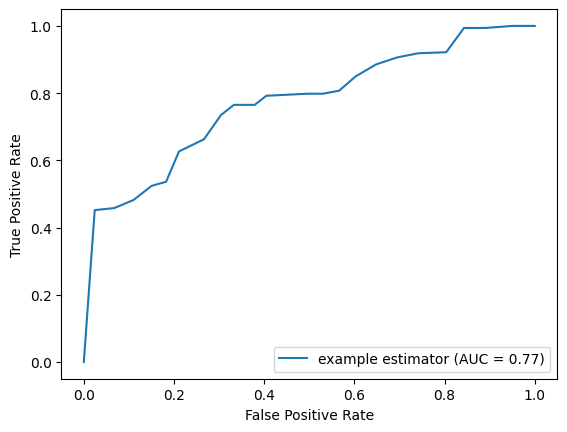

SKlearn precision:  0.518093644394268
Homemade precision:  0.5234244283324038
SKlearn recall:  0.5234244283324038
SKlearn F1:  0.5234244283324038
SKlearn AUC:  0.7722308092017192


In [88]:
get_metrics(df_train, df_test, "rbio3.7", DT_classification, get_DT_error)

### K Fold Cross Validation

In [28]:
def sklearn_k_fold_cross_validation (model, x_train, y_train):
    scores = cross_val_score(model, x_train, y_train)
    errors = 1 - scores
    return scores, errors

In [6]:
test_model = svm.SVC(kernel = "rbf")

#test_score, sklearn_k_fold_cross_validation(test_model, df_train_x, df_train_y)

In [24]:

test_model = svm.SVC(kernel = "rbf", probability = True)
kf = KFold(n_splits=2)

df_train_x_t, df_train_y_t = proccess_letters(df_train, wavelet="db4")
df_test_x_t, df_test_y_t = proccess_letters(df_test, wavelet="db4")


df_training_x = np.array(df_train_x_t + df_test_x_t)
df_training_y = np.array(df_train_y_t + df_test_y_t)

for train_index, test_index in kf.split(df_training_x):
    X_train, X_test = df_training_x[train_index], df_training_x[test_index]
    y_train, y_test = df_training_y[train_index], df_training_y[test_index]
    
    test_model = test_model.fit(X_train, y_train)
    roc_test = roc_auc_score(y_test, test_model.predict_proba(X_test), multi_class='ovr')

    print(roc_test)

0.9998183752613209
0.9985594181958316
